<a href="https://colab.research.google.com/github/estherkxy/GA_Projects/blob/main/Capstone/code/4_WordEmbeddingsModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install transformers
!pip install tweet-preprocessor

In [2]:
import tensorflow as tf

from sklearn import metrics
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers.embeddings import Embedding

import preprocessor as p
import numpy as np
import pandas as pd
import time
import datetime
import random
import io
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

print('Tensorflow version: ', tf.__version__)

Tensorflow version:  2.8.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Loading datasets
tw = pd.read_csv('./drive/My Drive/GA/capstone/data/tweets_train.csv', encoding = 'latin-1')
train_df = pd.read_csv('./drive/My Drive/GA/capstone/data/train_tweets_clean.csv')

# Train-Validation Split

In [5]:
# Doing a 80-20 split
X_train = train_df.loc[:2514, 'text'].values
y_train = train_df.loc[:2514, 'sentiment'].values
X_val = train_df.loc[2514:, 'text'].values
y_val = train_df.loc[2514:, 'sentiment'].values

# Tokenizing & Padding

In [6]:
tokenizer_obj = Tokenizer()
total_tweets = train_df['text'].values
tokenizer_obj.fit_on_texts(total_tweets)

# pad sequences
max_length = max([len(s.split()) for s in total_tweets])

# define vocab size 
vocab_size = len(tokenizer_obj.word_index) + 1

X_train_tokens = tokenizer_obj.texts_to_sequences(X_train)
X_val_tokens = tokenizer_obj.texts_to_sequences(X_val)

X_train_pad = pad_sequences(X_train_tokens, maxlen=max_length, padding='post')
X_val_pad = pad_sequences(X_val_tokens, maxlen=max_length, padding='post')

# Building the model (GRU)

In [9]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 4.1 MB/s 


In [46]:
import tensorflow_addons as tfa
embedding_dim = 100

print('Building model...')

# This callback will stop the training when there is no improvement in
# the loss for one consecutive epoch.
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(GRU(units=64, dropout=0.5, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['acc',tfa.metrics.F1Score(num_classes=1),
                       tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

Building model...


In [47]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 29, 100)           668300    
                                                                 
 gru_4 (GRU)                 (None, 64)                31872     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 700,237
Trainable params: 700,237
Non-trainable params: 0
_________________________________________________________________


# Train model

In [48]:
print('Training GRU model...')

history = model.fit(X_train_pad, y_train, batch_size=64, epochs=10, 
                    validation_data=(X_val_pad, y_val), callbacks=[callback], verbose=2)


Training GRU model...
Epoch 1/10
40/40 - 8s - loss: 0.6565 - acc: 0.6386 - f1_score: 0.5305 - precision_3: 0.4815 - recall_3: 0.0143 - val_loss: 0.6272 - val_acc: 0.7006 - val_f1_score: 0.4627 - val_precision_3: 1.0000 - val_recall_3: 0.0053 - 8s/epoch - 189ms/step
Epoch 2/10
40/40 - 4s - loss: 0.6385 - acc: 0.6465 - f1_score: 0.5305 - precision_3: 0.8800 - recall_3: 0.0242 - val_loss: 0.5965 - val_acc: 0.6576 - val_f1_score: 0.4627 - val_precision_3: 0.4356 - val_recall_3: 0.4656 - 4s/epoch - 96ms/step
Epoch 3/10
40/40 - 3s - loss: 0.4452 - acc: 0.7948 - f1_score: 0.5305 - precision_3: 0.7322 - recall_3: 0.6806 - val_loss: 0.4663 - val_acc: 0.7755 - val_f1_score: 0.4627 - val_precision_3: 0.6333 - val_recall_3: 0.6032 - 3s/epoch - 76ms/step
Epoch 4/10
40/40 - 2s - loss: 0.2540 - acc: 0.9074 - f1_score: 0.5305 - precision_3: 0.9042 - recall_3: 0.8315 - val_loss: 0.5210 - val_acc: 0.7611 - val_f1_score: 0.4627 - val_precision_3: 0.5890 - val_recall_3: 0.6825 - 2s/epoch - 61ms/step


In [50]:
# Creating DataFrames for each metric
loss = pd.DataFrame(history.history['loss'], columns = ['train_loss'])
acc = pd.DataFrame(history.history['acc'], columns = ['train_acc'])
val_loss = pd.DataFrame(history.history['val_loss'], columns = ['val_loss'])
val_acc = pd.DataFrame(history.history['val_acc'], columns = ['val_acc'])
f1 = pd.DataFrame(history.history['f1_score'], columns = ['f1_score'])
precision = pd.DataFrame(history.history['precision_3'], columns = ['precision'])
recall = pd.DataFrame(history.history['recall_3'], columns = ['recall'])


# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = loss.join(acc).join(val_loss).join(val_acc).join(f1).join(precision).join(recall)

# Use the 'epoch' as the row index.
df_stats['epoch'] = np.arange(len(df_stats))+1
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df_stats = df_stats.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,train_loss,train_acc,val_loss,val_acc,f1_score,precision,recall
epoch,,,,,,,
1,0.66,0.64,0.63,0.70,0.53,0.48,0.01
2,0.64,0.65,0.60,0.66,0.53,0.88,0.02
3,0.45,0.79,0.47,0.78,0.53,0.73,0.68
4,0.25,0.91,0.52,0.76,0.53,0.90,0.83


As seen from the table above, while the training scores improved, the validation loss and accuracy is barely passable. This indicates that the model is very overfitted. However, it should be noted that precision and recall score has improved drastically to 96% each. 

In [14]:
# Exporting results
df_stats.to_csv('./drive/My Drive/GA/capstone/data/wordembeddings_results_df.csv')

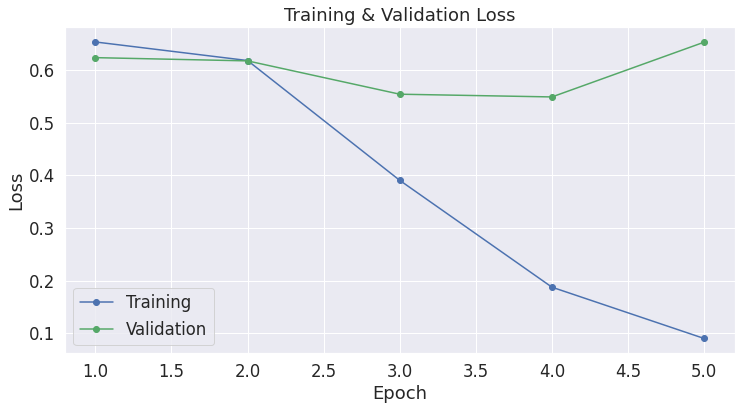

In [21]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['train_loss'], 'b-o', label="Training")
plt.plot(df_stats['val_loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
#plt.xticks([1, 2, 3, 4])

plt.show()

In [51]:
train_pred = model.predict(x=X_train_pad)
val_pred = model.predict(x=X_val_pad)

In [52]:
train_pred_df = pd.DataFrame(train_pred, columns=['predictions'])
train_pred_df['predictions'] = train_pred_df['predictions'].map(lambda x: 1 if x > 0.5 else 0)
train_pred_df['predictions'].value_counts()

0    1610
1     905
Name: predictions, dtype: int64

In [53]:
val_df = pd.DataFrame(val_pred, columns=['predictions'])
val_df['predictions'] = val_df['predictions'].map(lambda x: 1 if x > 0.5 else 0)
val_df['predictions'].value_counts()

0    409
1    219
Name: predictions, dtype: int64

In [54]:
import numpy as np
from sklearn.metrics import confusion_matrix

def conf_unravel(true,pred):
  tn, fp, fn, tp = confusion_matrix(true, pred).ravel()
  print("True Negatives: %s" % tn)
  print("False Positives: %s" % fp)
  print("False Negatives: %s" % fn)
  print("True Positives: %s" % tp)

  accuracy_clean = (tp + tn) / (tp + tn + fp + fn)
  print(f'Accuracy: {round(accuracy_clean,4)}')

  misclass_clean = (fp + fn) / (tp + tn + fp + fn)
  print(f'Misclassification Rate: {round(misclass_clean,4)}')

  spec_clean = tn / (tn + fp) #how many of the negatives was correctly classified
  print(f'Specificity: {round(spec_clean,4)}')

  sens_clean = tp / (tp + fn) #how many of the negatives was correctly identified
  print(f'Sensitivity: {round(sens_clean,4)}')

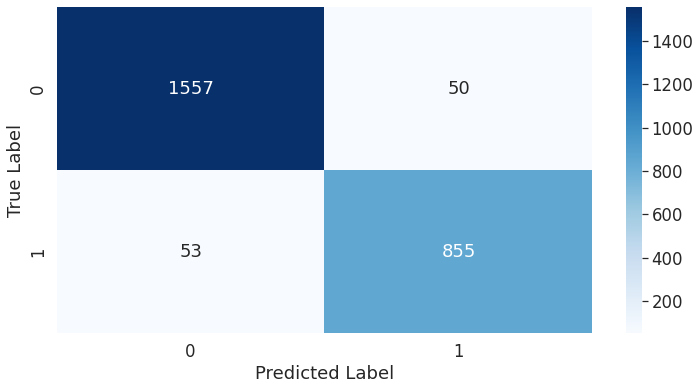

In [55]:
import seaborn as sns
sns.heatmap(confusion_matrix(y_train,train_pred_df['predictions']),annot=True,fmt='g',cmap=plt.cm.Blues);
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix_bert.png')

In [56]:
conf_unravel(y_train,train_pred_df['predictions'])

True Negatives: 1557
False Positives: 50
False Negatives: 53
True Positives: 855
Accuracy: 0.959
Misclassification Rate: 0.041
Specificity: 0.9689
Sensitivity: 0.9416


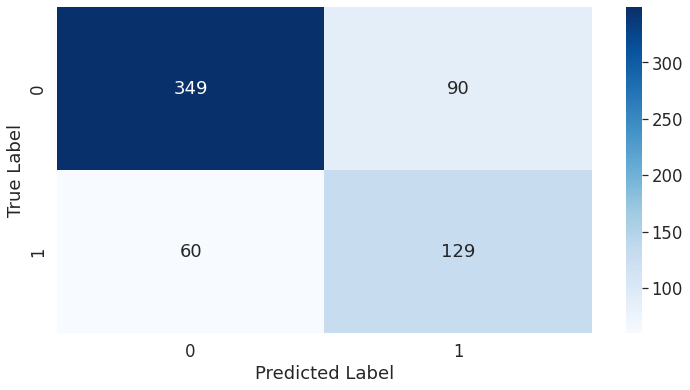

In [57]:
import seaborn as sns
sns.heatmap(confusion_matrix(y_val,val_df['predictions']),annot=True,fmt='g',cmap=plt.cm.Blues);
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix_bert.png')

In [58]:
conf_unravel(y_val,val_df['predictions'])

True Negatives: 349
False Positives: 90
False Negatives: 60
True Positives: 129
Accuracy: 0.7611
Misclassification Rate: 0.2389
Specificity: 0.795
Sensitivity: 0.6825


# Performance on Test Set

In [69]:
# importing test data
test_df = pd.read_csv('./drive/My Drive/GA/capstone/data/tweets_test.csv')
test_df.head()

,id,text,sentiment
0,1,Wow. Yall needa step it up @Apple RT @heynyla:...,-1
1,2,What Happened To Apple Inc? http://t.co/FJEX...,0
2,3,Thank u @apple I can now compile all of the pi...,1
3,4,The oddly uplifting story of the Apple co-foun...,0
4,5,@apple can i exchange my iphone for a differen...,0


In [70]:
# Reclassifying the target sentiments to binary (0: non-negative, 1: negative)
test_df['sentiment'].replace(1,0, inplace = True)
test_df['sentiment'].replace(-1,1, inplace = True)
test_df.head()

,id,text,sentiment
0,1,Wow. Yall needa step it up @Apple RT @heynyla:...,1
1,2,What Happened To Apple Inc? http://t.co/FJEX...,0
2,3,Thank u @apple I can now compile all of the pi...,0
3,4,The oddly uplifting story of the Apple co-foun...,0
4,5,@apple can i exchange my iphone for a differen...,0


In [71]:
# Tokenize test set
test_tokens = tokenizer_obj.texts_to_sequences(test_df['text'].values)
test_tokens_pad = pad_sequences(test_tokens, maxlen=max_length)

In [72]:
# predict 
predictions = model.predict(x=test_tokens_pad)

In [73]:
predictions

array([[0.82064474],
       [0.1850627 ],
       [0.25189283],
       ...,
       [0.2219817 ],
       [0.14596125],
       [0.33871645]], dtype=float32)

In [74]:
pred_df = pd.DataFrame(predictions, columns=['predictions'])

In [75]:
pred_df['sentiment'] = pred_df['predictions'].map(lambda x: 1 if x > 0.5 else 0)

In [76]:
pred_df['sentiment'].value_counts()

0    1098
1     532
Name: sentiment, dtype: int64

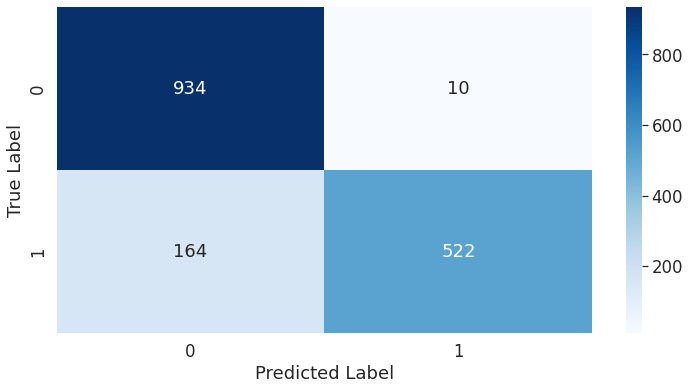

In [77]:
import seaborn as sns
sns.heatmap(confusion_matrix(test_df['sentiment'],pred_df['sentiment']),annot=True,fmt='g',cmap=plt.cm.Blues);
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix_bert.png')

In [78]:
conf_unravel(test_df['sentiment'],pred_df['sentiment'])

True Negatives: 934
False Positives: 10
False Negatives: 164
True Positives: 522
Accuracy: 0.8933
Misclassification Rate: 0.1067
Specificity: 0.9894
Sensitivity: 0.7609


As seen from the confusion matrices above, when testing on the validation and test sets, the model faces some trouble when trying to correctly identify negative tweets as compared to the training confusion matrix. This indicates that the model is slightly overfitted. Overall, the model has done reasonably well in predicting with more room for improvement when predicting negative tweets.